# 2- Supervised Learning

In this tutorial, we're going to learn how to define a model, and train it using a supervised approach, to solve a multiclass classifaction task.

The tutorial demonstrates how to:

* Pre-process the (train and test) data, to facilitate learning
* Describe a model to solve a classification task
* Choose a loss function to minimize
* Define a sampling procedure (stochastic, mini-batches), and apply one of several optimization techniques to train the model's parameters
* Estimate the model's performance on unseen (test) data

Resources:
- [Machine Learning with Torch7 (Code)](https://github.com/torch/tutorials)
- [Supervised Learning (Description)](https://github.com/clementfarabet/ipam-tutorials/tree/master/th_tutorials/1_supervised)

## Step 1: Data

For this tutorial, we'll be using the [Street View House Number dataset](http://ufldl.stanford.edu/housenumbers/). SVHN is a real-world image dataset for developing machine learning and object recognition algorithms with minimal requirement on data preprocessing and formatting. It can be seen as similar in flavor to MNIST (e.g., the images are of small cropped digits), but incorporates an order of magnitude more labeled data (over 600,000 digit images) and comes from a significantly harder, unsolved, real world problem (recognizing digits and numbers in natural scene images). SVHN is obtained from house numbers in Google Street View images.

Overview of the dataset:

- 10 classes, 1 for each digit. Digit '1' has label 1, '9' has label 9 and '0' has label 10.
- 73257 digits for training, 26032 digits for testing, and 531131 additional, somewhat less difficult samples, to use as extra training data
- Comes in two formats:
    * Original images with character level bounding boxes.
    * MNIST-like 32-by-32 images centered around a single character (many of the images do contain some distractors at the sides).

We will be using the second format. In terms of dimensionality:

- the inputs (images) are 3x32x32
- the outputs (targets) are 10-dimensional

In [1]:
----------------------------------------------------------------------
-- This script demonstrates how to load the (SVHN) House Numbers 
-- training data, and pre-process it to facilitate learning.
--
-- The SVHN is a typical example of supervised training dataset.
-- The problem to solve is a 10-class classification problem, similar
-- to the quite known MNIST challenge.
--
-- It's a good idea to run this script with the interactive mode:
-- $ th -i 1_data.lua
-- this will give you a Torch interpreter at the end, that you
-- can use to analyze/visualize the data you've just loaded.
--
-- Clement Farabet
----------------------------------------------------------------------
require 'torch'   -- torch
require 'image'   -- for color transforms
require 'nn'      -- provides a normalization operator
require 'paths'   -- checking if file exists
require 'xlua'    -- xlua provides useful tools, like progress bars
require 'optim'   -- an optimization package, for online and batch methods

----------------------------------------------------------------------
opt = {}
print '==> processing options'
print('opt.size: how many samples do we load: (small) (10k training, 2k testing) | full (73k training, 26k testing)')
print('opt.visualize: visualize input data and weights during training: (true) | false')
print('opt.seed: fixed input seed for repeatable experiments: (1)')
print('opt.threads: number of threads: (8)')
print('opt.model: type of model to construct: linear | mlp | (convnet)')
print('opt.loss: type of loss function to minimize: (nll) | mse | margin')
print('opt.save: subdirectory to save/log experiments in: (results)')
print('opt.plot: live plot: (true) | false')
print('opt.optimization: optimization method: (SGD) | ASGD | CG | LBFGS')
print('opt.learningRate: learning rate at t=0: (1e-3)')
print('opt.batchSize: mini-batch size (1 = pure stochastic): (1)')
print('opt.weightDecay: weight decay (SGD only): (0)')
print('opt.momentum: momentum (SGD only): (0)')
print('opt.t0: start averaging at t0 (ASGD only), in nb of epochs: (1)')
print('opt.maxIter: maximum nb of iterations for CG and LBFGS: (2)')
print('opt.type: (double) | float | cuda')

opt.size = 'small'
opt.visualize = true
opt.seed = 1
opt.threads = 8
opt.model = 'convnet'
opt.loss = 'nll'
opt.save = 'results'
opt.plot = true
opt.optimization = 'SGD'
opt.learningRate = 1e-3
opt.batchSize = 1
opt.weightDecay = 0
opt.momentum = 0
opt.t0 = 1
opt.maxIter = 2
opt.type = 'double'

-- nb of threads and fixed seed (for repeatable experiments)
if opt.type == 'float' then
   print('==> switching to floats')
   torch.setdefaulttensortype('torch.FloatTensor')
elseif opt.type == 'cuda' then
   print('==> switching to CUDA')
   require 'cunn'
   torch.setdefaulttensortype('torch.FloatTensor')
end
torch.setnumthreads(opt.threads)
torch.manualSeed(opt.seed)


==> processing options	
opt.size: how many samples do we load: (small) (10k training, 2k testing) | full (73k training, 26k testing)	
opt.visualize: visualize input data and weights during training: (true) | false	
opt.seed: fixed input seed for repeatable experiments: (1)	
opt.threads: number of threads: (8)	
opt.model: type of model to construct: linear | mlp | (convnet)	
opt.loss: type of loss function to minimize: (nll) | mse | margin	
opt.save: subdirectory to save/log experiments in: (results)	
opt.plot: live plot: (true) | false	
opt.optimization: optimization method: (SGD) | ASGD | CG | LBFGS	
opt.learningRate: learning rate at t=0: (1e-3)	
opt.batchSize: mini-batch size (1 = pure stochastic): (1)	
opt.weightDecay: weight decay (SGD only): (0)	
opt.momentum: momentum (SGD only): (0)	
opt.t0: start averaging at t0 (ASGD only), in nb of epochs: (1)	
opt.maxIter: maximum nb of iterations for CG and LBFGS: (2)	
opt.type: (double) | float | cuda	


In [2]:
print '==> downloading dataset'

-- Here we download dataset files. 

-- Note: files were converted from their original Matlab format
-- to Torch's internal format using the mattorch package. The
-- mattorch package allows 1-to-1 conversion between Torch and Matlab
-- files.

-- The SVHN dataset contains 3 files:
--    + train: training data
--    + test:  test data
--    + extra: extra training data

-- By default, we don't use the extra training data, as it is much 
-- more time consuming

if (not paths.filep("train_32x32.t7")) then
    os.execute('wget http://torch7.s3-website-us-east-1.amazonaws.com/data/housenumbers/train_32x32.t7')
end
if (not paths.filep("test_32x32.t7")) then
    os.execute('wget http://torch7.s3-website-us-east-1.amazonaws.com/data/housenumbers/test_32x32.t7')
end


if (opt.size == 'small') then
    train_size = 10000
    test_size = 2000
    print 'Using small dataset'
elseif (opt.size == 'full') then
    train_size = 10000
    test_size = 2000  
    print 'Using full dataset'
end

==> downloading dataset	
Using small dataset	


In [3]:
----------------------------------------------------------------------
print '==> loading dataset'

-- We load the dataset from disk, and re-arrange it to be compatible
-- with Torch's representation. Matlab uses a column-major representation,
-- Torch is row-major, so we just have to transpose the data.

-- Note: the data, in X, is 4-d: the 1st dim indexes the samples, the 2nd
-- dim indexes the color channels (RGB), and the last two dims index the
-- height and width of the samples.

-- Load the training dataset
raw_data = torch.load("train_32x32.t7","ascii")
--print(#raw_data.X)
--print(#raw_data.y)
--print(raw_data.y[1][14])
--itorch.image(raw_data.X[14])
trainSet = {
    data = raw_data.X:transpose(3,4),
    labels = raw_data.y[1],
    size = function() return train_size end
}
-- itorch.image(trainSet.data[3])

-- Load the testing dataset
raw_data = torch.load("test_32x32.t7","ascii")
testSet = {
    data = raw_data.X:transpose(3,4),
    labels = raw_data.y[1],
    size = function() return test_size end
}


==> loading dataset	


In [4]:
----------------------------------------------------------------------
print '==> preprocessing data'

-- Preprocessing requires a floating point representation (the original
-- data is stored on bytes). Types can be easily converted in Torch, 
-- in general by doing: dst = src:type('torch.TypeTensor'), 
-- where Type=='Float','Double','Byte','Int',... Shortcuts are provided
-- for simplicity (float(),double(),cuda(),...):

trainSet.data = trainSet.data:float()
testSet.data = testSet.data:float()

-- We now preprocess the data. Preprocessing is crucial
-- when applying pretty much any kind of machine learning algorithm.
-- For natural images, we use several intuitive tricks:
-- * images are mapped into YUV space, to separate luminance information from color information.
-- * the luminance channel (Y) is locally normalized, using a contrastive 
--   normalization operator: for each neighborhood, defined by a Gaussian
--   kernel, the mean is suppressed, and the standard deviation is normalized to one.
-- * color channels are normalized globally, across the entire dataset;
--   as a result, each color component has 0-mean and 1-norm across the dataset.

-- Convert all images to YUV
print '==> preprocessing data: colorspace RGB -> YUV'
for i = 1,trainSet:size() do
    trainSet.data[i] = image.rgb2yuv(trainSet.data[i])
end
for i = 1,testSet:size() do
    testSet.data[i] = image.rgb2yuv(testSet.data[i])
end

-- Name channels for convenience
channels = {'y','u','v'}

-- Normalize each channel, and store mean/std
-- per channel. These values are important, as they are part of
-- the trainable parameters. At test time, test data will be normalized
-- using these values.
print '==> preprocessing data: normalize each feature (channel) globally'
mean = {}
stdv = {}
for i = 1,3 do
    -- normalize each channel globally:
    mean[i] = trainSet.data[{ {},{i},{},{} }]:mean() -- mean estimation
    print('Channel ' .. i .. ' mean: ' .. mean[i])
    trainSet.data[{ {},{i},{},{} }]:add(-mean[i]) -- mean subtraction
    testSet.data[{ {},{i},{},{} }]:add(-mean[i]) -- mean subtraction
    
    stdv[i] = trainSet.data[{ {},{i},{},{} }]:std() -- std estimation
    print('Channel ' .. i .. ' Standard Deviation: ' .. stdv[i])
    trainSet.data[{ {},{i},{},{} }]:div(stdv[i]) -- std division
    testSet.data[{ {},{i},{},{} }]:div(stdv[i]) -- std division
end

-- Local normalization
print '==> preprocessing data: normalize all three channels locally'

-- Define the normalization neighborhood:
neighborhood = image.gaussian1D(13)

-- Define our local normalization operator (It is an actual nn module,
-- which could be inserted into a trainable model):
normalization = nn.SpatialContrastiveNormalization(1, neighborhood,1):float()

-- Normalize all channels locally:
for c in ipairs(channels) do
    for i = 1,trainSet:size() do
        trainSet.data[{ {i},{c},{},{} }] = normalization:forward(trainSet.data[{ {i},{c},{},{} }])
    end
    for i = 1,testSet:size() do
        testSet.data[{ {i},{c},{},{} }] = normalization:forward(testSet.data[{ {i},{c},{},{} }])
    end
end


----------------------------------------------------------------------


==> preprocessing data	


==> preprocessing data: colorspace RGB -> YUV	


==> preprocessing data: normalize each feature (channel) globally	


Channel 1 mean: 111.85664054059	


Channel 1 Standard Deviation: 50.467668872064	


Channel 2 mean: 98.071901586681	


Channel 2 Standard Deviation: 60.806183690649	


Channel 3 mean: 103.83652386792	


Channel 3 Standard Deviation: 62.810269950963	


==> preprocessing data: normalize all three channels locally	


==> verify statistics	


Training Set Channel 1 mean: -0.006313964130324	


Testing Set Channel 1 mean: 0.064013399412288	


Training Set Channel 1 Standard Deviation: 0.94085703702485	


Testing Set Channel 1 Standard Deviation: 1.071276998706	


Training Set Channel 2 mean: 0.21264134455774	


Testing Set Channel 2 mean: 0.26287914265976	


Training Set Channel 2 Standard Deviation: 0.78796429042957	


Testing Set Channel 2 Standard Deviation: 0.91655089439651	


Training Set Channel 3 mean: 0.22919727583664	


Testing Set Channel 3 mean: 0.23141433715934	


Training Set Channel 3 Standard Deviation: 0.74868942342819	


Testing Set Channel 3 Standard Deviation: 0.89402614301349	
==> visualizing data	


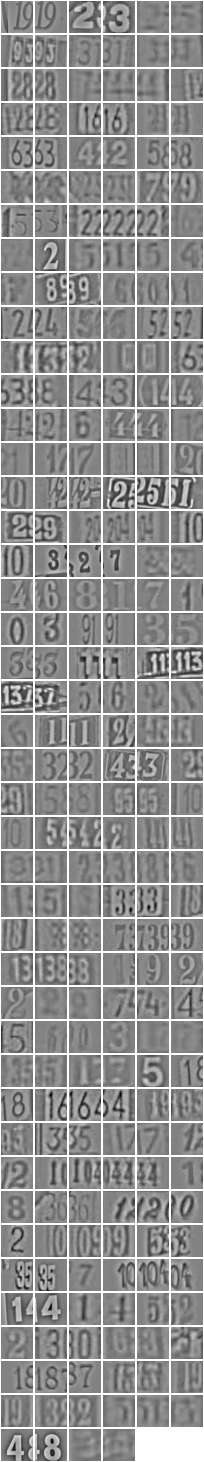

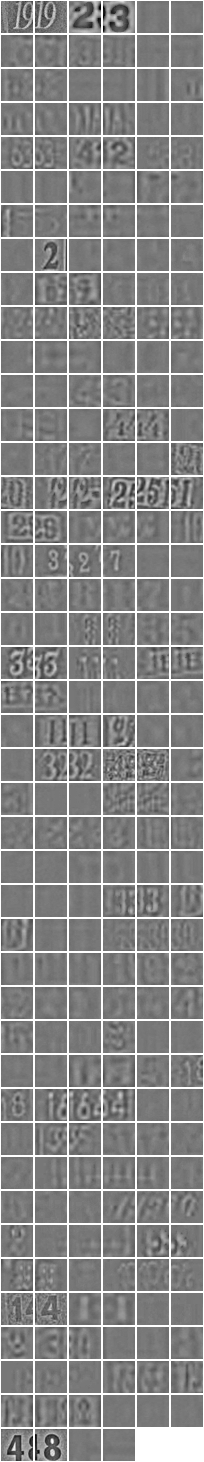

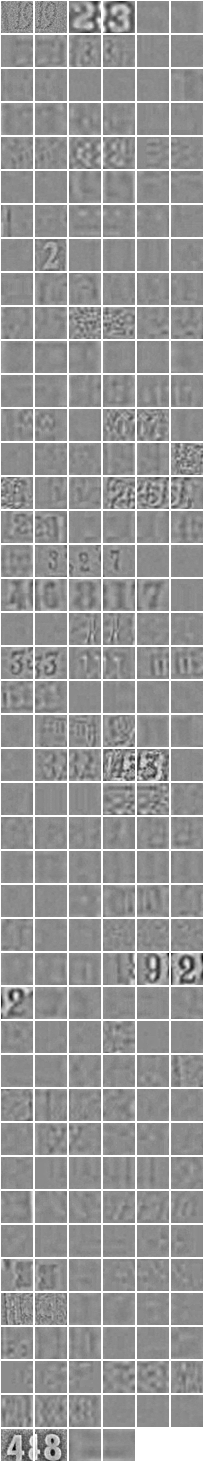

In [5]:
print '==> verify statistics'
-- It's always good practice to verify that data is properly normalized

for i = 1,3 do
    print('Training Set Channel ' .. i .. ' mean: ' .. trainSet.data[{ {},{i},{},{} }]:mean())
    print('Testing Set Channel ' .. i .. ' mean: ' .. testSet.data[{ {},{i},{},{} }]:mean())
    
    print('Training Set Channel ' .. i .. ' Standard Deviation: ' .. trainSet.data[{ {},{i},{},{} }]:std())
    print('Testing Set Channel ' .. i .. ' Standard Deviation: ' .. testSet.data[{ {},{i},{},{} }]:std())

end

----------------------------------------------------------------------
print '==> visualizing data'
-- Visualization is quite easy, using itorch.image().

if opt.visualize then
    if itorch then
        first256samples_y = trainSet.data[{ {1,256},{1},{},{}}]
        first256samples_u = trainSet.data[{ {1,256},{2},{},{}}]
        first256samples_v = trainSet.data[{ {1,256},{3},{},{}}]
        itorch.image(first256samples_y)
        itorch.image(first256samples_u)
        itorch.image(first256samples_v)
    else print("For visualization, run this script in an itorch notebook") 
    end
end
        

## Step 2: Model Definition

In this file, we describe three different models: convolutional neural networks (CNNs, or ConvNets), multi-layer neural networks (MLPs), and a simple linear model (which becomes a logistic regression if used with a negative log-likelihood loss).

Linear regression is the simplest type of model. It is parametrized by a weight matrix W, and a bias vector b. Mathematically, it can be written as:
$$ y^n = Wx^n+b $$

Using the nn package, describing ConvNets, MLPs and other forms of sequential trainable models is really easy. All we have to do is create a top-level wrapper, which, as for the logistic regression, is going to be a sequential module, and then append modules into it. Implementing a simple linear model is therefore trivial:
```torch
model = nn.Sequential()
model:add(nn.Reshape(ninputs))
model:add(nn.Linear(ninputs, noutputs))
```

A slightly more complicated model is the multi-layer neural network (MLP). This model is parametrized by two weight matrices, and two bias vectors:
$$ y^n = W_2 \text{sigmoid}(W_1 x^n + b_1) + b_2 $$

where the function sigmoid is typically the symmetric hyperbolic tangent function. Again, in Torch:
```torch
model = nn.Sequential()
model:add(nn.Reshape(ninputs))
model:add(nn.Linear(ninputs,nhiddens))
model:add(nn.Tanh())
model:add(nn.Linear(nhiddens,noutputs))
```

Compared to the linear regression model, the 2-layer neural network can learn arbitrary non-linear mappings between its inputs and outputs. In practice, it can be quite hard to train fully-connected MLPs to classify natural images.

Convolutional Networks are a particular form of MLP, which was tailored to efficiently learn to classify images. Convolutional Networks are trainable architectures composed of multiple stages. The input and output of each stage are sets of arrays called feature maps. For example, if the input is a color image, each feature map would be a 2D array containing a color channel of the input image (for an audio input each feature map would be a 1D array, and for a video or volumetric image, it would be a 3D array). At the output, each feature map represents a particular feature extracted at all locations on the input. 

Each stage is composed of three layers: a **filter bank layer**, a **non-linearity layer**, and a **feature pooling layer**. A typical ConvNet is composed of one, two or three such 3-layer stages, followed by a **classification module**. Each layer type is now described for the case of image recognition.
![Convolutional Networds](./2_supervised_img1_convnet.png)

Trainable hierarchical vision models, and more generally image processing algorithms are usually expressed as sequences of operations or transformations. They can be well described by a modular approach, in which each module processes an input image bank and produces a new bank. The figure above is a nice graphical illustration of this approach. Each module requires the previous bank to be fully (or at least partially) available before computing its output. This causality prevents simple parallelism to be implemented across modules. However parallelism can easily be introduced within a module, and at several levels, depending on the kind of underlying operations. These forms of parallelism are exploited in Torch7.

Typical ConvNets rely on a few basic modules:
* **Filter bank layer**: the input is a 3D array with n1 2D feature maps of size n2 x n3. Each component is denoted $x_{ijk}$, and each feature map is denoted xi. The output is also a 3D array, y composed of m1 feature maps of size m2 x m3. A trainable filter (kernel) $k_{ij}$ in the filter bank has size l1 x l2 and connects input feature map x to output feature map $y_j$. The module computes $y_j = b_j + i_{kij} * x_i$ where $*$ is the 2D discrete convolution operator and $b_j$ is a trainable bias parameter. Each filter detects a particular feature at every location on the input. Hence spatially translating the input of a feature detection layer will translate the output but leave it otherwise unchanged.
* **Non-Linearity Layer**: In traditional ConvNets this simply consists in a pointwise tanh() sigmoid function applied to each site (ijk). However, recent implementations have used more sophisticated non-linearities. A useful one for natural image recognition is the rectified sigmoid Rabs: $|g_i.tanh()|$ where $g_i$ is a trainable gain parameter. The rectified sigmoid is sometimes followed by a subtractive and divisive local normalization N, which enforces local competition between adjacent features in a feature map, and between features at the same spatial location.
* **Feature Pooling Layer**: This layer treats each feature map separately. In its simplest instance, it computes the average values over a neighborhood in each feature map. Recent work has shown that more selective poolings, based on the LP-norm, tend to work best, with P=2, or P=inf (also known as max pooling). The neighborhoods are stepped by a stride larger than 1 (but smaller than or equal the pooling neighborhood). This results in a reduced-resolution output feature map which is robust to small variations in the location of features in the previous layer. The average operation is sometimes replaced by a max PM. Traditional ConvNets use a pointwise tanh() after the pooling layer, but more recent models do not. Some ConvNets dispense with the separate pooling layer entirely, but use strides larger than one in the filter bank layer to reduce the resolution. In some recent versions of ConvNets, the pooling also pools similar feature at the same location, in addition to the same feature at nearby locations.

A couple of comments about the model that we are going to use:
* the input has 3 feature maps, each 32x32 pixels. It is the convention for all nn.Spatial* layers to work on 3D arrays, with the first dimension indexing different features (here normalized YUV), and the next two dimensions indexing the height and width of the image/map.
* the fist layer applies 16 filters to the input map, each being 5x5. The receptive field of this first layer is 5x5, and the maps produced by it are therefore 16x28x28. This linear transform is then followed by a non-linearity (tanh), and an L2-pooling function, which pools regions of size 2x2, and uses a stride of 2x2. The result of that operation is a 16x14x14 array, which represents a 14x14 map of 16-dimensional feature vectors. The receptive field of each unit at this stage is 7x7.
* the second layer is very much analogous to the first, except that now the 16-dim feature maps are projected into 256- dim maps, with a fully-connected connection table: each unit in the output array is influenced by a 4x5x5 neighborhood of features in the previous layer. That layer has therefore 4x256x5x5 trainable kernel weights (and 256 biases). The result of the complete layer (conv+pooling) is a 256x5x5 array.
* at this stage, the 5x5 array of 256-dimensional feature vectors is flattened into a 6400-dimensional vector, which we feed to a two-layer neural net. The final prediction (10-dimensional distribution over classes) is influenced by a 32x32 neighborhood of input variables (YUV pixels).
* recent work (Jarret et al.) has demonstrated the advantage of locally normalizing sets of internal features, at each stage of the model. The use of smoother pooling functions, such as the L2 norm for instance instead of the harsher max-pooling, has also been shown to yield better generalization (Sermanet et al.). We use these two ingredients in this model.
* one other remark: it is typically not a good idea to use fully connected layers, in internal layers. In general, favoring large numbers of features (over-completeness) over density of connections helps achieve better results (empirical evidence of this was reported in several papers, as in Hadsell et al.). The SpatialConvolutionMap module accepts tables of connectivities (maps) that allows one to create arbitrarily sparse connections between two layers. A couple of standard maps/tables are provided in nn.tables.



==> define parameters	
==> construct model	


==> here is the model:	
nn.Sequential {
  [input -> (1) -> (2) -> (3) -> (4) -> (5) -> (6) -> (7) -> (8) -> (9) -> (10) -> (11) -> (12) -> output]
  (1): nn.SpatialConvolutionMap
  (2): nn.Tanh
  (3): nn.Sequential {
    [input -> (1) -> (2) -> (3) -> (4) -> output]
    (1): nn.Square
    (2): nn.SpatialAveragePooling(2x2, 2,2)
    (3): nn.MulConstant
    (4): nn.Sqrt
  }
  (4): nn.SpatialSubtractiveNormalization
  (5): nn.SpatialConvolutionMap
  (6): nn.Tanh
  (7): nn.Sequential {
    [input -> (1) -> (2) -> (3) -> (4) -> output]
    (1): nn.Square
    (2): nn.SpatialAveragePooling(2x2, 2,2)
    (3): nn.MulConstant
    (4): nn.Sqrt
  }
  (8): nn.SpatialSubtractiveNormalization
  (9): nn.Reshape(1600)
  (10): nn.Linear(1600 -> 128)
  (11): nn.Tanh
  (12): nn.Linear(128 -> 10)
}
{
  gradInput : DoubleTensor - empty
  modules : 
    {
      1 : 
        nn.SpatialConvolutionMap
        {
          dH : 1
          dW : 1
          nInputPlane : 3
          kW : 5
          gradInput : Do

        _type : torch.DoubleTensor
          output : DoubleTensor - empty
        }
      3 : 
        nn.Sequential {
          [input -> (1) -> (2) -> (3) -> (4) -> output]
          (1): nn.Square
          (2): nn.SpatialAveragePooling(2x2, 2,2)
          (3): nn.MulConstant
          (4): nn.Sqrt
        }
        {
          dH : 2
          dW : 2
          _type : torch.DoubleTensor
          output : DoubleTensor - empty
          gradInput : DoubleTensor - empty
          modules : 
            {
              1 : 
                nn.Square
                {
                  gradInput : DoubleTensor - empty
                  _type : torch.DoubleTensor
                  output : DoubleTensor - empty
                }
              2 : 
                nn.SpatialAveragePooling(2x2, 2,2)
                {
                  dH : 2
                  dW : 2
                  kW : 2
                  gradInput : DoubleTensor - empty
                  divide : true
                

            nn.Sequential {
              [input -> (1) -> (2) -> (3) -> (4) -> output]
              (1): nn.SpatialZeroPadding(l=3, r=3, t=3, b=3)
              (2): nn.SpatialConvolutionMap
              (3): nn.SpatialConvolution(64 -> 1, 1x7)
              (4): nn.Replicate
            }
            {
              gradInput : DoubleTensor - empty
              modules : 
                {
                  1 : nn.SpatialZeroPadding(l=3, r=3, t=3, b=3)
                  2 : nn.SpatialConvolutionMap
                  3 : nn.SpatialConvolution(64 -> 1, 1x7)
                  4 : nn.Replicate
                }
              _type : torch.DoubleTensor
              output : DoubleTensor - empty
            }
          output : DoubleTensor - empty
        }
      5 : 
        nn.SpatialConvolutionMap
        {
          dH : 1
          dW : 1
          nInputPlane : 64
          kW : 5
          gradInput : DoubleTensor - empty
          connTable : DoubleTensor - size: 256x2
       

           }
          meanestimator : 
            nn.Sequential {
              [input -> (1) -> (2) -> (3) -> (4) -> output]
              (1): nn.SpatialZeroPadding(l=3, r=3, t=3, b=3)
              (2): nn.SpatialConvolutionMap
              (3): nn.SpatialConvolution(64 -> 1, 1x7)
              (4): nn.Replicate
            }
            {
              gradInput : DoubleTensor - empty
              modules : 
                {
                  1 : nn.SpatialZeroPadding(l=3, r=3, t=3, b=3)
                  2 : nn.SpatialConvolutionMap
                  3 : nn.SpatialConvolution(64 -> 1, 1x7)
                  4 : nn.Replicate
                }
              _type : torch.DoubleTensor
              output : DoubleTensor - empty
            }
          output : DoubleTensor - empty
        }
      9 : 
        nn.Reshape(1600)
        {
          _type : torch.DoubleTensor
          output : DoubleTensor - empty
          gradInput : DoubleTensor - empty
          size : LongStor

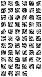

Normal Convnet Layer 2 filters:	


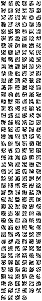

In [6]:
-- This script demonstrates how to define a couple of different
-- models:
--   + linear
--   + 2-layer neural network (MLP)
--   + convolutional network (ConvNet)
--
-- Clement Farabet
----------------------------------------------------------------------

print '==> define parameters'

-- 10 class problem
noutputs = 10

-- input dimensions
nfeats = 3
width = 32
height = 32
ninputs = nfeats * width * height

-- number of hidden units (for MLP only):
nhiddens = ninputs / 2

-- hidden units, filter size (for ConvNets only):
nstates = {64,64,128}
fanin = {1,4}
filtsize = 5
poolsize = 2
normkernel = image.gaussian1D(7)

----------------------------------------------------------------------
print '==> construct model'
if opt.model == 'linear' then
    -- Simple linear model
    model = nn.Sequential()
    model:add(nn.Reshape(ninputs))
    model:add(nn.Linear(nhiddens, noutputs))
    
elseif opt.model == 'mlp' then
    -- Simple 2-layer neural network, with tanh hidden units
    model = nn.Sequential()
    model:add(nn.Reshape(ninputs))
    model:add(nn.Linear(ninputs, nhiddens))
    model:add(nn.Tanh())
    model:add(nn.Linear(nhiddens, noutputs))

elseif opt.model == 'convnet' then
    if opt.type == 'cuda' then
        -- a typical modern convolution network (conv+relu+pool)
        model = nn.Sequential()
        
        -- stage 1 : filter bank -> squashing -> L2 pooling -> normalization
        model:add(nn.SpatialConvolutionMap(nn.tables.random(nfeats, nstates[1], fanin[1]), filtsize, filtsize))
        model:add(nn.ReLU())
        model:add(nn.SpatialMaxPooling(poolsize, poolsize, poolsize, poolsize))
        
        -- stage 2 : filter bank -> squashing -> L2 pooling -> normalization
        model:add(nn.SpatialConvolutionMap(nn.tables.random(nstates[1], nstates[2], fanin[2]), filtsize, filtsize))
        model:add(nn.ReLU())
        model:add(nn.SpatialMaxPooling(poolsize, poolsize, poolsize, poolsize))
        
        -- stage 3 : standard 2-layer neural network
        model:add(nn.View(nstates[2]*filtsize*filtsize))
        model:add(nn.Dropout(0.5))
        model:add(nn.Linear(nstates[2]*filtsize*filtsize, nstates[3]))
        model:add(nn.ReLU())
        model:add(nn.Linear(nstates[3], noutputs))
        
    else 
        -- a typical convolutional network, with locally-normalized hidden
        -- units, and L2-pooling
        -- Note: the architecture of this convnet is loosely based on Pierre Sermanet's
        -- work on this dataset (http://arxiv.org/abs/1204.3968). In particular
        -- the use of LP-pooling (with P=2) has a very positive impact on
        -- generalization. Normalization is not done exactly as proposed in
        -- the paper, and low-level (first layer) features are not fed to
        -- the classifier.
        model = nn.Sequential()
        
        -- stage 1 : filter bank -> squashing -> L2 pooling -> normalization
        model:add(nn.SpatialConvolutionMap(nn.tables.random(nfeats, nstates[1], fanin[1]), filtsize, filtsize))
        model:add(nn.Tanh())
        model:add(nn.SpatialLPPooling(nstates[1], 2, poolsize, poolsize, poolsize, poolsize))
        model:add(nn.SpatialSubtractiveNormalization(nstates[1],normkernel))
        
        -- stage 2 : filter bank -> squashing -> L2 pooling -> normalization
        model:add(nn.SpatialConvolutionMap(nn.tables.random(nstates[1], nstates[2], fanin[2]), filtsize, filtsize))
        model:add(nn.Tanh())
        model:add(nn.SpatialLPPooling(nstates[2], 2, poolsize, poolsize, poolsize, poolsize))
        model:add(nn.SpatialSubtractiveNormalization(nstates[2],normkernel))
        
        -- stage 3 : standard 2-layer neural network
        model:add(nn.Reshape(nstates[2]*filtsize*filtsize))
        model:add(nn.Linear(nstates[2]*filtsize*filtsize, nstates[3]))
        model:add(nn.Tanh())
        model:add(nn.Linear(nstates[3], noutputs))
    end
else
    print('unknown -model')
end

----------------------------------------------------------------------
print '==> here is the model:'
print(model)

----------------------------------------------------------------------
-- Visualization is quite easy, using itorch.image().
if opt.visualize == true then
    if itorch then
        print('==> visualizing ConvNet filters')
        if opt.model == 'linear' then
            print('Linear Layer 1 filters:')
            itorch.image(model.modules[2].weight)
        elseif opt.model == 'mlp' then
            print('MLP Layer 1 filters:')
            itorch.image(model.modules[2].weight)
        elseif opt.model == 'convnet' then
            if opt.type == 'cuda' then
                print('CUDA Convnet Layer 1 filters:')
                itorch.image(model.modules[1].weight)
                print('CUDA Convnet Layer 2 filters:')
                itorch.image(model.modules[4].weight)
            else
                print('Normal Convnet Layer 1 filters:')
                itorch.image(model.modules[1].weight)
                print('Normal Convnet Layer 2 filters:')
                itorch.image(model.modules[5].weight)
            end
        else error('Wrong NN Model') end
    else print('For visualization, run this script in an itorch notebook') 
    end
end

## Step 3: Loss Function

Now that we have a model, we need to define a loss function to be minimized, across the entire training set:

$$ L = \sum_n l(y^n,t^n) $$

One of the simplest loss functions we can minimize is the **mean-square error** between the predictions (outputs of the model), and the groundtruth labels, across the entire dataset:

$$ l(y^n,t^n) = \frac{1}{2} \sum_i (y_i^n - t_i^n)^2 $$

or, in Torch:
```torch
criterion = nn.MSECriterion()
```

The MSE loss is typically not a good one for classification, as it forces the model to exactly predict the values imposed by the targets (labels).

Instead, a more commonly used, probabilistic objective is the **negative log-likelihood**. To minimize a negative log-likelihood, we first need to turn the predictions of our models into properly normalized log-probabilities. For the linear model, this is achieved by feeding the output units into a softmax function, which turns the linear regression into a logistic regression:

$$ P(Y=i|x^n,W,b) = \text{softmax}(Wx^n+be) $$ 
$$ P(Y=i|x^n,W,b) = \frac{ e^{Wx_i^n+b} }{ \sum_j e^{Wx_j^n+b} } $$

As we're interested in classification, the final prediction is then achieved by taking the argmax of this distribution:

$$ y^n = \arg\max_i P(Y=i|x^n,W,b) $$

in which case the ouput y is a scalar.

More generally, the output of any model can be turned into normalized log-probabilities, by stacking a softmax function on top. So given any of the models defined above, we can simply do:
```torch
model:add( nn.LogSoftMax() )
```

We want to maximize the likelihood of the correct (target) class, for each sample in the dataset. This is equivalent to minimizing the **negative log-likelihood (NLL)**, or minimizing the cross-entropy between the predictions of our model and the targets (training data). Mathematically, the per-sample loss can be defined as:

$$ l(x^n,t^n) = -\log(P(Y=t^n|x^n,W,b)) $$

Given that our model already produces log-probabilities (thanks to the softmax), the loss is quite straightforward to estimate. In Torch, we use the ClassNLLCriterion, which expects its input as being a vector of log-probabilities, and the target as being an integer pointing to the correct class:
```torch
criterion = nn.ClassNLLCriterion()
```

Finally, another type of classification loss is the **multi-class margin loss**, which is closer to the well-known SVM loss. This loss function doesn't require normalized outputs, and can be implemented like this:
```torch
criterion = nn.MultiMarginCriterion()
```

The margin loss typically works on par with the negative log-likelihood. I haven't tested this thoroughly, so it's time for more exercises.


In [7]:
----------------------------------------------------------------------
-- This script demonstrates how to define a couple of different
-- loss functions:
--   + negative-log likelihood, using log-normalized output units (SoftMax)
--   + mean-square error
--   + margin loss (SVM-like)
--
-- Clement Farabet
----------------------------------------------------------------------

print '==> define loss'

if opt.loss == 'margin' then
    -- This loss takes a vector of classes, and the index of
    -- the grountruth class as arguments. It is an SVM-like loss
    -- with a default margin of 1.
    criterion = nn.MultiMarginCriterion()

elseif opt.loss == 'nll' then
    -- This loss requires the outputs of the trainable model to
    -- be properly normalized log-probabilities, which can be
    -- achieved using a softmax function
    model:add(nn.LogSoftMax())
    
    -- The loss works like the MultiMarginCriterion: it takes
    -- a vector of classes, and the index of the grountruth class
    -- as arguments.
    criterion = nn.ClassNLLCriterion()

elseif opt.loss == 'mse' then    
    -- The mean-square error is not recommended for classification
    -- tasks, as it typically tries to do too much, by exactly modeling
    -- the 1-of-N distribution. For the sake of showing more examples,
    -- we still provide it here:
    criterion = nn.MSECriterion()
    
    -- Compared to the other losses, the MSE criterion needs a distribution
    -- as a target, instead of an index. Indeed, it is a regression loss!
    -- So we need to transform the entire label vectors:
    if trainSet then
        -- convert training labels:
        local trsize = train_size
        local trlabels = torch.Tensor(trsize, noutputs)
        trlabels:fill(-1)
        for i = 1,trsize do trlabels[{i,trainSet.labels[i]}] = 1 end
        trainSet.labels = trlabels
        
        -- convert training labels:
        local tesize = test_size
        local telabels = torch.Tensor(tesize, noutputs)
        telabels:fill(-1)
        for i = 1,tesize do telabels[{i,testSet.labels[i]}] = 1 end
        testSet.labels = telabels
    end

else 
    error('error: unknown -class')
end

----------------------------------------------------------------------
print '==> here is the loss function:'
print(opt.loss)
--print(criterion)

==> define loss	
==> here is the loss function:	
nll	


## Step 4: Training Procedure

We now have some training data, a model to train, and a loss function to minimize. We define a training procedure.

A very important aspect about supervised training of non-linear models (ConvNets and MLPs) is the fact that the optimization problem is not convex anymore. This reinforces the need for a stochastic estimation of gradients, which have shown to produce much better generalization results for several problems.

In this example, we show how the optimization algorithm can be easily set to either L-BFGS, CG, SGD or ASGD. In practice, it's very important to start with a few epochs of pure SGD, before switching to L-BFGS or ASGD (if switching at all). The intuition for that is related to the non-convex nature of the problem: at the very beginning of training (random initialization), the landscape might be highly non-convex, and no assumption should be made about the shape of the energy function. Often, SGD is the best we can do. Later on, batch methods (L-BFGS, CG) can be used more safely.

Interestingly, in the case of large convex problems, stochasticity is also very important, as it allows much faster (rough) convergence. Several works have explored these techniques, in particular, this recent paper from Byrd/Nocedal, and work on pure stochastic gradient descent by Bottou.

Here is our full training function, which demonstrates that you can switch the optimization you're using at runtime (if you want to), and also modify the batch size you're using at run time. You can do all these things because we create the evaluation closure each time we create a new batch. If the batch size is 1, then the method is purely stochastic. If the batch size is set to the complete dataset, then the method is a pure batch method.

In [8]:
----------------------------------------------------------------------
-- This script demonstrates how to define a training procedure,
-- irrespective of the model/loss functions chosen.
--
-- It shows how to:
--   + construct mini-batches on the fly
--   + define a closure to estimate (a noisy) loss
--     function, as well as its derivatives wrt the parameters of the
--     model to be trained
--   + optimize the function, according to several optmization
--     methods: SGD, L-BFGS.
--
-- Clement Farabet
----------------------------------------------------------------------

----------------------------------------------------------------------
-- CUDA?
if opt.type == 'cuda' then
    model:cuda()
    criterion:cuda()
end

----------------------------------------------------------------------
print '==> defining some tools'

-- classes
classes = {'1','2','3','4','5','6','7','8','9','0'}

-- This matrix records the current confusion across classes
confusion = optim.ConfusionMatrix(classes)

-- Log results to files
trainLogger = optim.Logger(paths.concat(opt.save, 'train.log'))
testLogger = optim.Logger(paths.concat(opt.save, 'test.log'))

-- Retrieve parameters and gradients:
-- this extracts and flattens all the trainable parameters of the mode
-- into a 1-dim vector
if model then
    parameters,gradParameters = model:getParameters()
end

----------------------------------------------------------------------
print '==> configuring optimizer'

if opt.optimization == 'CG' then
    optimState = {maxIter = opt.maxIter}
    optimMethod = optim.cg
    
elseif opt.optimization == 'LBFGS' then
    optimState = {
        learningRate = opt.learningRate,
        maxIter = opt.maxIter,
        nCorrection = 10
    }
    optimMethod = optim.lbfgs

elseif opt.optimization == 'SGD' then
    optimState = {
        learningRate = opt.learningRate,
        weightDecay = opt.weightDecay,
        momentum = opt.momentum,
        learningRateDecay = 1e-17
    }
    optimMethod = optim.sgd
    
elseif opt.optimization == 'ASGD' then
    optimState = {
        eta0 = opt.learningRate,
        t0 = train_size * opt.t0
    }
    optimMethod = optim.asgd
else error('unknown optimization method')
end

----------------------------------------------------------------------
print '==> defining training procedure'

function train()
    -- epoch tracker
    epoch = epoch or 1
    
    -- local vars
    local time = sys.clock()
    
    -- set model to training mode (for modules that differ in training and testing, like Dropout)
    model:training()
    
    -- shuffle at each epoch
    shuffle = torch.randperm(train_size)
    
    -- do one epoch
    print('==> doing epoch on training data:')
    print("==> online epoch # " .. epoch .. ' [batchSize = ' .. opt.batchSize .. ']')
    
    for t = 1,trainSet:size(), opt.batchSize do
        -- disp progress
        xlua.progress(t, trainSet:size())
        
        -- create mini batch
        local inputs = {}
        local targets = {}
        
        for i = t,math.min(t+opt.batchSize-1, trainSet:size()) do
            -- load new sample
            local input = trainSet.data[shuffle[i]]
            local target = trainSet.labels[shuffle[i]]
            
            if opt.type == 'double' then
                input = input:double()
                if opt.loss == 'mse' then target = target:double() end
            elseif opt.type == 'cuda' then
                input = input:cuda()
                if opt.loss == 'mse' then target = target:cuda() end
            end
            
            table.insert(inputs,input)
            table.insert(targets, target)
        end
        
        -- create closure to evaluate f(X) and df/dX
        local feval = function(x)
            -- get new parameters
            if x ~= parameters then parameters:copy(x) end
            
            -- reset gradients
            gradParameters:zero()
            
             -- f is the average of all criterions
            local f = 0
            
            -- evaluate function for complete mini batch
            for i = 1,#inputs do
                -- estimate f
                local output = model:forward(inputs[i])
                local err = criterion:forward(output, targets[i])
                f = f + err
                
                -- estimate df/dW
                local df_dw = criterion:backward(output, targets[i])
                model:backward(inputs[i], df_dw)
                
                -- update confusion
                confusion:add(output, targets[i])
            end
            
            -- normalize gradients and f(X)
            gradParameters:div(#inputs)
            f = f/#inputs
            
            -- return f and df/dX
            return f, gradParameters
        end
        
        -- optimize on current mini-batch
        if optimMethod == optim.asgd then _,_,average = optimMethod(feval, parameters, optimState)
        else optimMethod(feval, parameters, optimState)
        end
    end
    
    -- time taken
    time = sys.clock() - time
    time = time / trainSet:size()
    print("\n==> time to learn 1 sample = " .. (time*1000) .. 'ms')
    
    -- print confusion matrix
    print(confusion)
    
    -- update logger/plot
    trainLogger:add{['% mean class accuracy (train set)'] = confusion.totalValid * 100}
    if opt.plot then
        trainLogger:style{['% mean class accuracy (train set)'] = '-'}
        trainLogger:plot()
    end
    
    -- save/log current net
    local filename = paths.concat(opt.save, 'model.net')
    os.execute('mkdir -p ' .. sys.dirname(filename))
    print('==> saving model to '..filename)
    torch.save(filename, model)
    
    -- next epoch
    confusion:zero()
    epoch = epoch + 1
end

==> defining some tools	


==> configuring optimizer	
==> defining training procedure	


## Step 5: Test the Model

A common thing to do is to test the model's performance while we train it. Usually, this test is done on a subset of the training data, that is kept for validation. Here we simply define the test procedure on the available test set:

In [9]:
----------------------------------------------------------------------
-- This script implements a test procedure, to report accuracy
-- on the test data. Nothing fancy here...
--
-- Clement Farabet
----------------------------------------------------------------------

print '==> defining test procedure'

-- test function
function test()
    -- local vars
    local time = sys.clock()
    
    -- averaged param use?
    if average then
        cachedparams = parameters:clone()
        parameters:copy(average)
    end
    
    -- set model to evaluate mode (for modules that differ in training and testing, like Dropout)
    model:evaluate()
    
    -- test over test data
    print('==> testing on test set:')
    
    for t = 1,testSet:size() do
        -- disp progress
        xlua.progress(t, testSet:size())
        
        -- get new sample
        local input = testSet.data[t]
        if opt.type == 'double' then input = input:double()
        elseif opt.type == 'cuda' then input = input:cuda() end
        local target = testSet.labels[t]
        
        -- test sample
        local pred = model:forward(input)
        confusion:add(pred, target)
    end
    
    -- timing
    time = sys.clock() - time
    time = time / testSet:size()
    print("\n==> time to test 1 sample = " .. (time*1000) .. 'ms')
    
    -- print confusion matrix
    print(confusion)
    
    -- update log/plot
    testLogger:add{['% mean class accuracy (test set)'] = confusion.totalValid * 100}
    if opt.plot then
        testLogger:style{['% mean class accuracy (test set)'] = '-'}
        testLogger:plot()
    end
    
    -- averaged param use?
    if average then 
        -- restore parameters
        parameters:copy(cachedparams)
    end
    
    -- next iteration:
    confusion:zero()
end

==> defining test procedure	


In [ ]:
----------------------------------------------------------------------
print '==> training!'

for i =1,10 do
   train()
   test()
end

==> training!	
==> doing epoch on training data:	
==> online epoch # 1 [batchSize = 1]	


 [=============================>................]                                ETA: 40s93ms | Step: 11ms 